In [6]:
# ============= PREAMBLE =============
# Last Edited By: Luca Carnegie 
# Date: March 29, 2025
# Description: Creates a Poisson regression model to predict the number of days until bloom
# based on the historic temperature data.
# =====================================

from matplotlib import pyplot as plt
from matplotlib.pyplot import subplots
import pandas as pd
import numpy as np
import statsmodels.api as sm
import numpy as np



# Load the data
sakura_historic = pd.read_csv("../data/analysis_data/historic_bloom.csv")
sakura_historic_modern = pd.read_csv("../data/analysis_data/merged_historic_modern_bloom.csv")

# Make all rows with NaN values 0
sakura_historic = sakura_historic.replace({np.nan: 0})
sakura_historic_modern = sakura_historic_modern.replace({0})

C:\Users\lucac\AppData\Local\Temp\ipykernel_5796\741516256.py:23: FutureWarning: DataFrame.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  sakura_historic_modern = sakura_historic_modern.replace({0})


Deprecated *again*: Poisson regression won't work...

In [15]:
# Filter to non-censored observations
non_censored = sakura_historic[sakura_historic['censored'] == 0]

# Define X and y
X = non_censored[['avg_temp_march_c']]
X = sm.add_constant(X)  # Add intercept
y = non_censored['flower_doy']

# Fit Poisson model
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

# Print results
print(poisson_model.summary())

# Example prediction for a specific temperature
new_temp = 10.5  # Example March temperature in °C
new_X = pd.DataFrame({'const': [1], 'avg_temp_march_c': [new_temp]})
predicted_doy = poisson_model.predict(new_X)[0]
print(f"Predicted flowering day of year for temperature {new_temp}°C: {predicted_doy:.1f}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:             flower_doy   No. Observations:                  827
Model:                            GLM   Df Residuals:                      825
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2709.2
Date:                Sun, 30 Mar 2025   Deviance:                       53.564
Time:                        18:37:44   Pearson chi2:                     50.3
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2797
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                4.8316      0.011  

In [16]:
# Check for overdispersion (variance > mean)
mean_doy = y.mean()
variance_doy = y.var()
print(f"Mean: {mean_doy:.2f}, Variance: {variance_doy:.2f}")

if variance_doy > mean_doy:
    print("Overdispersion detected, consider Negative Binomial model")
    nb_model = sm.GLM(y, X, family=sm.families.NegativeBinomial()).fit()
    print(nb_model.summary())

Mean: 104.54, Variance: 41.05


Poisson Regression Assumption:

## Poisson Regression Assumptions:

1. **Independence**: Observations must be independent of each other.

2. **Mean equals variance (equidispersion)**: In Poisson distribution, the mean and variance should be equal. Our data shows variance (41.05) < mean (104.54), indicating overdispersion.

3. **Logarithmic link function**: The model uses a log link function to relate the mean of the response to the linear predictors.

4. **Linearity**: The log of the expected count should be linearly related to the predictors.

5. **No excessive zeros**: Poisson regression assumes no excess of zero counts beyond what would be expected from the Poisson distribution.

6. **No multicollinearity**: Predictors should not be highly correlated with each other.

7. **Large sample size**: Poisson regression generally requires a large sample size for reliable estimates.

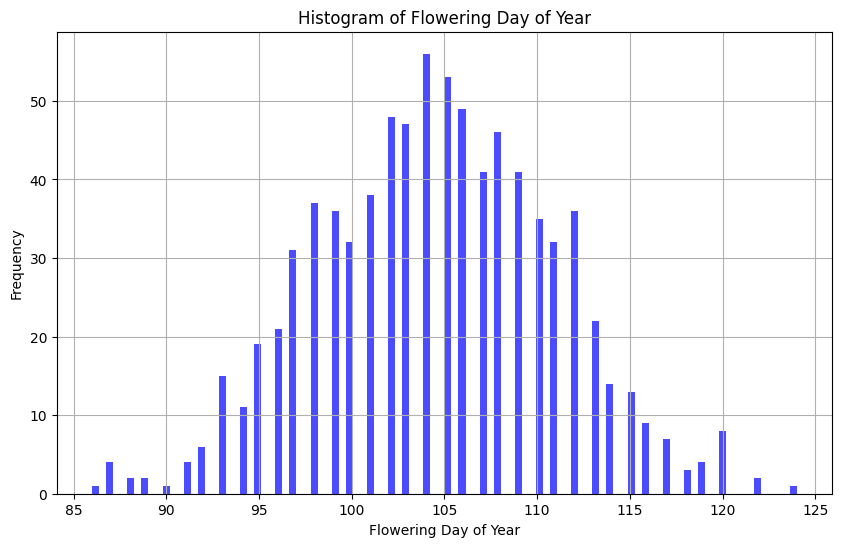

In [19]:
# Plot that Y is skewed
plt.figure(figsize=(10, 6))
plt.hist(y, bins=100, color='blue', alpha=0.7)
plt.title('Histogram of Flowering Day of Year')
plt.xlabel('Flowering Day of Year')
plt.ylabel('Frequency')
plt.grid()
plt.show()

Deprecated: turns out the Cox Proportional Hazards Model doesn't really work for our data.

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplots
import pandas as pd
import numpy as np
from ISLP.models import ModelSpec as MS
from ISLP import load_data
from pickle import loads, dumps
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test 
from lifelines.utils import survival_table_from_events

import numpy as np


# Load the data
sakura_historic = pd.read_csv("../data/analysis_data/historic_bloom.csv")
sakura_historic_modern = pd.read_csv("../data/analysis_data/merged_historic_modern_bloom.csv")

# Make all rows with NaN values 0
sakura_historic = sakura_historic.replace({np.nan: 0})
sakura_historic_modern = sakura_historic_modern.replace({0})

In [ ]:
## FIT THE COX MODEL USING JUST HISTORICAL DATA ## 

# Create a Cox proportional hazards model object
coxph = CoxPHFitter

# Create a subset of data with relevant features
selected_df = sakura_historic[['flower_doy', 'censored', 'avg_temp_march_c']]

# Add an interaction term (temperature × time)
# First, standardize temperature to make interpretation easier
temp_mean = selected_df['avg_temp_march_c'].mean()
temp_std = selected_df['avg_temp_march_c'].std()
selected_df['avg_temp_march_c_std'] = (selected_df['avg_temp_march_c'] - temp_mean) / temp_std
                     
# Create model dataframe with transformed features
model_df = MS(['flower_doy', 'censored', 'avg_temp_march_c'], 
              intercept=False).fit_transform(selected_df)

# Create time interaction term
model_df['avg_temp_march_c_X_time'] = model_df['avg_temp_march_c'] * model_df['flower_doy']

# Fit the Cox model
cox_sakura_0 = coxph().fit(model_df,  # Use the transformed model matrix
                           duration_col='flower_doy',
                           event_col='censored')

# Display summary statistics
cox_sakura_0.print_summary()

C:\Users\lucac\AppData\Local\Temp\ipykernel_5796\491276152.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['avg_temp_march_c_std'] = (selected_df['avg_temp_march_c'] - temp_mean) / temp_std
c:\Users\lucac\AppData\Local\Programs\Python\Python313\Lib\site-packages\lifelines\utils\__init__.py:1120: ConvergenceWarning: Column avg_temp_march_c_X_time have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['censored'].astype(bool)
>>> print(df.loc[events, 'avg_temp_march_c_X_time'].var())
>>> print(df.loc[~events, 'avg_temp_march_c_X_time'].var())

A very low variance means that the column avg_t

<lifelines.CoxPHFitter: fitted with 1204 total observations, 827 right-censored observations>
             duration col = 'flower_doy'
                event col = 'censored'
      baseline estimation = breslow
   number of observations = 1204
number of events observed = 377
   partial log-likelihood = -1888.25
         time fit was run = 2025-03-30 22:03:30 UTC

---
                         coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                
avg_temp_march_c         0.01      1.01      0.08           -0.14            0.16                0.87                1.17
avg_temp_march_c_X_time -0.12      0.88      8.24          -16.27           16.02                0.00            9.09e+06

                         cmp to     z    p  -log2(p)
covariate                                           
avg_temp_march_c           0.00  0.12 0.91      0.14
avg_temp_march_c_X_time    0.00 -0.01 0.99      0.02
---
Concordance = 1.00
Partial AIC = 3780.50
log-likelihood ratio test = 1439.55 on 2 df
-log2(p) of ll-ratio test = inf


   Bootstrapping lowess lines. May take a moment...



c:\Users\lucac\AppData\Local\Programs\Python\Python313\Lib\site-packages\lifelines\utils\lowess.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=3.27914e-17): result may not be accurate.
  beta = linalg.solve(A, b, assume_a="pos", check_finite=False)


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1204 total observations, 827 right-censored observations>
         test_name = proportional_hazard_test

---
                              test_statistic      p  -log2(p)
avg_temp_march_c        km              0.00   1.00      0.00
                        rank           11.68 <0.005     10.63
avg_temp_march_c_X_time km              0.00   1.00      0.00
                        rank            0.00   1.00      0.00



1. Variable 'avg_temp_march_c' failed the non-proportional test: p-value is 0.0006.

   Advice 1: the functional form of the variable 'avg_temp_march_c' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'avg_temp_march_c' using pd.cut, and then specify it in
`strata=['avg_temp_march_c', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...



c:\Users\lucac\AppData\Local\Programs\Python\Python313\Lib\site-packages\lifelines\utils\lowess.py:54: LinAlgWarning: Ill-conditioned matrix (rcond=3.27914e-17): result may not be accurate.
  beta = linalg.solve(A, b, assume_a="pos", check_finite=False)



---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[[<Axes: xlabel='rank-transformed time\n(p=0.0006)'>,
  <Axes: xlabel='km-transformed time\n(p=1.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9998)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9992)'>]]

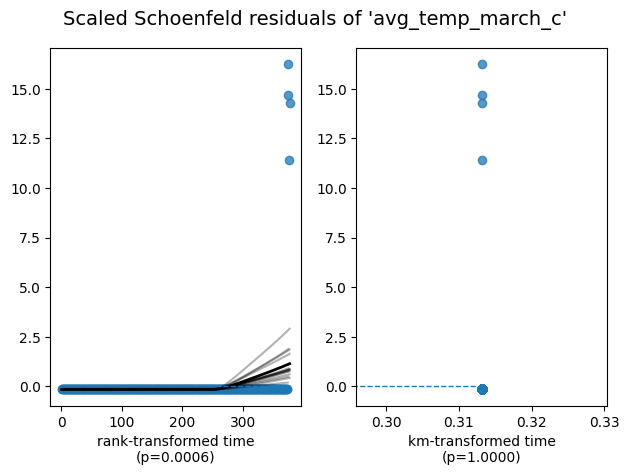

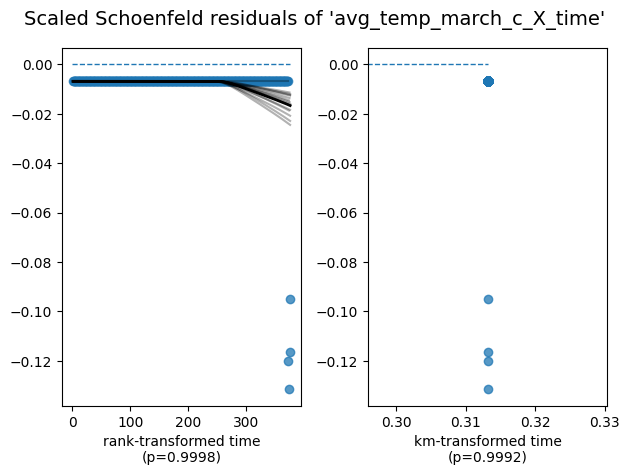

In [20]:
# Check proportional hazards assumption with Shoenfeld residuals
cox_sakura_0.check_assumptions(model_df, p_value_threshold=0.05, show_plots=True)

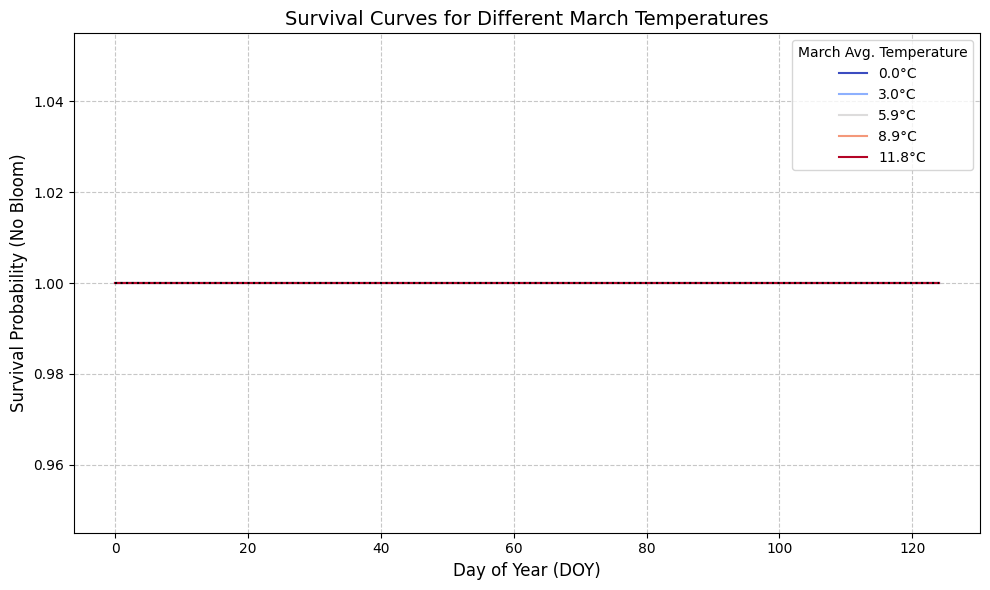

In [5]:
# Plot survival curves for different temperature values
fig, ax = plt.subplots(figsize=(10, 6))

# Get the range of temperatures in the data
temp_min = sakura_historic['avg_temp_march_c'].min()
temp_max = sakura_historic['avg_temp_march_c'].max()

# Create an array of temperatures to plot (low, medium, high)
temps_to_plot = np.linspace(temp_min, temp_max, 5)

# Plot survival curves for each temperature
cox_sakura_0.plot_partial_effects_on_outcome(
    covariates='avg_temp_march_c',
    values=temps_to_plot,
    cmap='coolwarm',
    ax=ax
)

# Improve plot appearance
ax.set_title('Survival Curves for Different March Temperatures', fontsize=14)
ax.set_xlabel('Day of Year (DOY)', fontsize=12)
ax.set_ylabel('Survival Probability (No Bloom)', fontsize=12)

# Add a legend with actual temperature values
legend_labels = [f'{temp:.1f}°C' for temp in temps_to_plot]
ax.legend(legend_labels, title='March Avg. Temperature', loc='best')

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()